# Class Distribution

> Train Dataset

```
MISSING: 94411 -> 94411 (selected 100%)
RAIN_ONLY: 9575 -> 94411 (copied x10) (Including "DRIZZLE_ONLY", "FREEZING_PRECIP")
SNOW_ONLY: 21465 -> 94411 (copied x5) (Including "RAIN_AND_SNOW")
```

> Test/Validation Dataset

```
MISSING: 1000
RAIN_ONLY: 1000 (Including "DRIZZLE_ONLY", "FREEZING_PRECIP")
SNOW_ONLY: 1000 (Including "RAIN_AND_SNOW")
```

# Load Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile
import os

file_names = ["reduced_class_train_images", "reduced_class_test_images", "reduced_class_val_images"]
folder_names = ["train_images", "test_images", "val_images"]

for file_name, folder_name in zip(file_names, folder_names):
  # Path to the ZIP file (could be from your Colab environment or Google Drive)
  zip_file_path = f'/content/drive/My Drive/Webcam_Project/datasets/reduced_class_images/{file_name}.zip'

  # Create target directory if it doesn't exist
  if not os.path.exists(folder_name):
      os.makedirs(folder_name)

  # Unzip the file
  with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
      zip_ref.extractall(folder_name)

  print(f'Files extracted to {folder_name}')

Files extracted to train_images
Files extracted to test_images
Files extracted to val_images


In [3]:
CLASS_NAMES = ['MISSING', 'RAIN_ONLY', 'SNOW_ONLY']

In [4]:
!find ./train_images/MISSING -maxdepth 1 -type f | wc -l
!find ./train_images/RAIN_ONLY -maxdepth 1 -type f | wc -l
!find ./train_images/SNOW_ONLY -maxdepth 1 -type f | wc -l

94411
94411
94411


In [5]:
!find ./test_images/MISSING -maxdepth 1 -type f | wc -l
!find ./test_images/RAIN_ONLY -maxdepth 1 -type f | wc -l
!find ./test_images/SNOW_ONLY -maxdepth 1 -type f | wc -l

1000
1000
1000


In [6]:
!find ./val_images/MISSING -maxdepth 1 -type f | wc -l
!find ./val_images/RAIN_ONLY -maxdepth 1 -type f | wc -l
!find ./val_images/SNOW_ONLY -maxdepth 1 -type f | wc -l

1000
1000
1000


# Finetuning Model

In [7]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim

In [8]:
from torchvision import datasets, transforms
import torch
from torch.utils.data import DataLoader

# Define your transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)), # Resize the image to 224x224 pixels
    transforms.ToTensor(),         # Convert the image to a PyTorch tensor
    transforms.Normalize([0.485, 0.456, 0.406], # Normalize using ImageNet mean and std
                         [0.229, 0.224, 0.225])
])

In [9]:
# Define the dataset using ImageFolder
train_dataset = datasets.ImageFolder(root='train_images/', transform=transform)
test_dataset = datasets.ImageFolder(root='test_images/', transform=transform)
val_dataset = datasets.ImageFolder(root='val_images/', transform=transform)

In [10]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [11]:
train_dataset.classes

['MISSING', 'RAIN_ONLY', 'SNOW_ONLY']

In [12]:
from torchvision import models
import torch.nn as nn

# Load pre-trained MobileNetV2
model = models.mobilenet_v2(pretrained=True)

# Number of features in the last layer of the model
num_ftrs = model.classifier[1].in_features

# Adjust the classifier to your number of classes
# Replace `num_classes` with the actual number of classes
num_classes = len(train_dataset.classes)  # Assuming 'dataset' is your ImageFolder dataset
model.classifier[1] = nn.Linear(num_ftrs, num_classes)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 155MB/s]


In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
import torch

num_epochs = 10  # Set the number of epochs
best_acc = 0.0  # To keep track of the best accuracy
stop_loss_threshold = 0.05  # Threshold for loss to stop training
stop_acc_threshold = 95.0  # Threshold for accuracy to stop training

epoch_loss_history = []
epoch_acc_history = []

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0

    # Training phase
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)

    # Validation phase
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # No gradients needed
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_acc = 100 * correct / total

    epoch_loss_history.append(epoch_loss)
    epoch_acc_history.append(epoch_acc)

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Val Accuracy: {epoch_acc:.2f}%')

    # Save model with highest accuracy
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        torch.save(model.state_dict(), "model_best_weights.pth")
        print("Model weights saved with accuracy: {:.2f}%".format(best_acc))

    # Stop training based on loss or accuracy
    if epoch_loss < stop_loss_threshold or epoch_acc > stop_acc_threshold:
        print(f'Stopping training at epoch {epoch+1} due to reaching a threshold.')
        break

print('Finished Training')

In [ ]:
epoch_loss_history

[0.4095560879895019,
 0.3087926217513795,
 0.2598122046221278,
 0.22764374188698983,
 0.2034705232374152,
 0.18471616895092724,
 0.16937822101911515,
 0.15652522555555293,
 0.14340736028700135,
 0.13281561913832357]

In [ ]:
epoch_acc_history

[84.73333333333333,
 84.43333333333334,
 85.33333333333333,
 85.76666666666667,
 84.5,
 84.7,
 85.1,
 83.96666666666667,
 82.26666666666667,
 83.73333333333333]

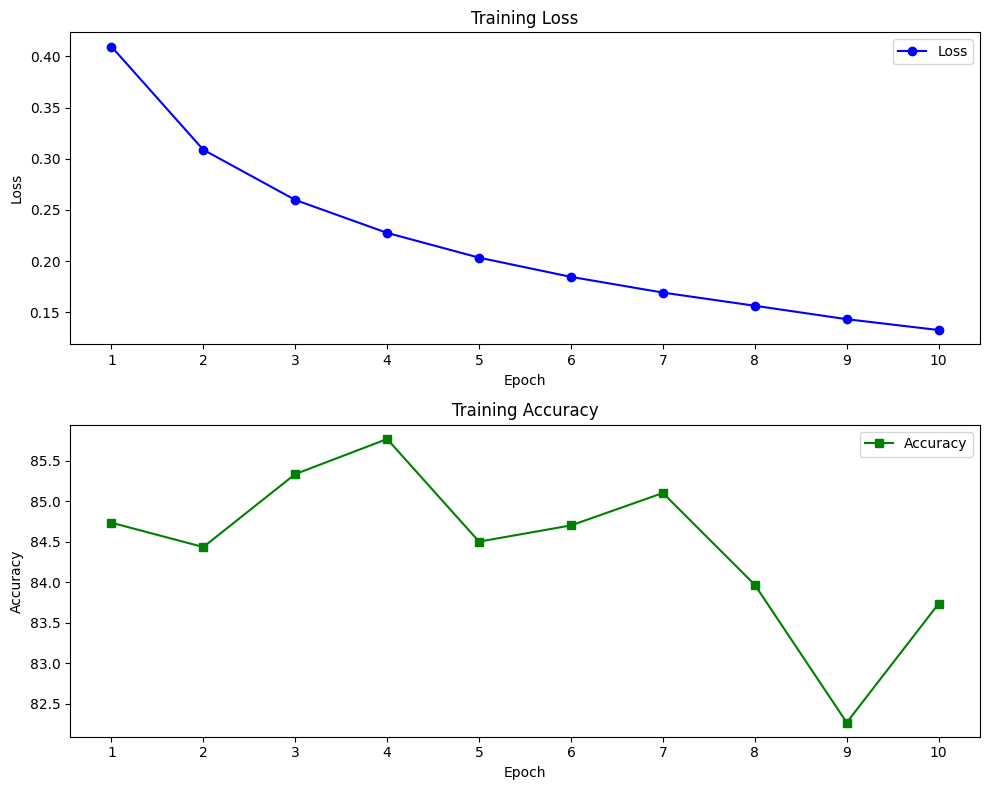

In [ ]:
import matplotlib.pyplot as plt

# Assuming epochs start at 1 and go up to the length of the history lists
epochs = range(1, len(epoch_loss_history) + 1)

# Set up the figure size and layout
plt.figure(figsize=(10, 8))

# Plot for the loss
plt.subplot(2, 1, 1)  # 2 rows, 1 column, 1st subplot
plt.plot(epochs, epoch_loss_history, 'bo-', label='Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs)  # Ensure x-axis labels show whole numbers for epochs
plt.legend()

# Plot for the accuracy
plt.subplot(2, 1, 2)  # 2 rows, 1 column, 2nd subplot
plt.plot(epochs, epoch_acc_history, 'gs-', label='Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(epochs)  # Ensure x-axis labels show whole numbers for epochs
plt.legend()

plt.tight_layout()
plt.show()

In [13]:
# Path to your saved model weights
model_weights_path = 'model_best_weights.pth'

# Load the weights into the model
model.load_state_dict(torch.load(model_weights_path, map_location=device))

<All keys matched successfully>

In [14]:
from google.colab import files
files.download('./model_best_weights.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Running Inference

In [15]:
# Validation phase
model.eval()  # Set model to evaluation mode
correct = 0
total = 0
with torch.no_grad():  # No gradients needed
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

acc = 100 * correct / total

print(f'Test Accuracy: {acc:.2f}%')

Test Accuracy: 84.20%


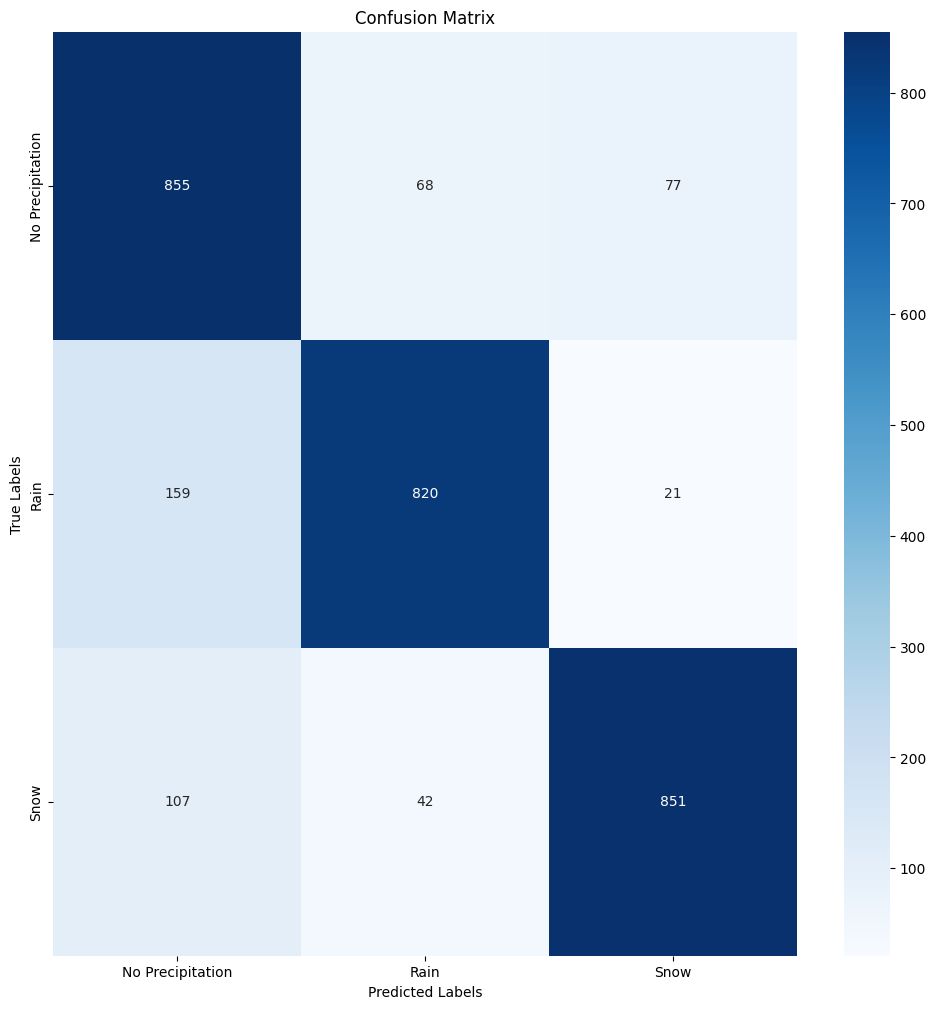

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import itertools

class_names = ["No Precipitation", "Rain", "Snow"]

model.eval()  # Set model to evaluation mode
all_preds = []
all_labels = []

with torch.no_grad():  # No gradients needed
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plotting the confusion matrix
fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=ax)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
plt.show()

In [17]:
# Calculate class accuracies from the confusion matrix
class_accuracies = cm.diagonal() / cm.sum(axis=1)

# Print class accuracies
print("Accuracy per class:")
for class_name, accuracy in zip(class_names, class_accuracies):
    print(f"{class_name}: {accuracy * 100:.2f}%")

Accuracy per class:
No Precipitation: 85.50%
Rain: 82.00%
Snow: 85.10%


# Match Rain (>= 3 deg) and Snow (<= -1 deg)

Measurements:
- For Precipitations (Rain or Snow)
- TP / Total for each Rain and Snow

In [18]:
provincial_code = ['AB', 'BC', 'MB', 'NF', 'NS', 'NT', 'NU', 'ON', 'QC', 'YT']
provincial_report = [code + '_ASOS_Matched.csv' for code in provincial_code]

In [19]:
import pandas as pd
import os

reports = {}

for report, code in zip(provincial_report, provincial_code):
    reports[code] = pd.read_csv(f"/content/drive/My Drive/Webcam_Project/Provincial_Matched/{report}")

<ipython-input-19-1d6ff0ce3159>:7: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  reports[code] = pd.read_csv(f"/content/drive/My Drive/Webcam_Project/Provincial_Matched/{report}")
<ipython-input-19-1d6ff0ce3159>:7: DtypeWarning: Columns (2,3,4,7) have mixed types. Specify dtype option on import or set low_memory=False.
  reports[code] = pd.read_csv(f"/content/drive/My Drive/Webcam_Project/Provincial_Matched/{report}")
<ipython-input-19-1d6ff0ce3159>:7: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  reports[code] = pd.read_csv(f"/content/drive/My Drive/Webcam_Project/Provincial_Matched/{report}")
<ipython-input-19-1d6ff0ce3159>:7: DtypeWarning: Columns (2,9) have mixed types. Specify dtype option on import or set low_memory=False.
  reports[code] = pd.read_csv(f"/content/drive/My Drive/Webcam_Project/Provincial_Matched/{report}")


In [20]:
report_comb = pd.concat([reports[code] for code in reports.keys()], keys=list(reports.keys()))

In [21]:
report_comb.head()

station             valid  tmpc    dwpc   relh    drct  sknt     mslp  \
AB 0    CYQF  2022-12-16 00:00  -8.0  -11.00  79.00  240.00  5.00  1032.60   
   1    CYQL  2022-12-16 00:00  -6.0   -9.00  79.31  250.00  4.00  1034.00   
   2    CYLL  2022-12-16 00:00 -15.0  -17.00  84.68  280.00  6.00  1030.50   
   3    CYOJ  2022-12-16 00:00 -12.0  -13.00  92.25  180.00  2.00  1028.70   
   4    CYZU  2022-12-16 00:00  -4.0   -7.00  79.62  290.00  4.00  1030.40   

      p01m   vsby  ...   Hail     GS     IP     DZ FZRA/FZDZ  \
AB 0   0.0   9.00  ...  False  False  False  False     False   
   1   0.0  25.00  ...  False  False  False  False     False   
   2   0.0   6.00  ...  False  False  False  False     False   
   3   0.0  10.00  ...  False  False  False  False     False   
   4   0.0  15.00  ...  False  False  False  False     False   

     precipitation_category             valid_dt matched_image_file  \
AB 0                MISSING  2022-12-16 00:00:00                NaN   
   1                MISSING  2022-12-16 00:00:00                NaN   
   2                    NaN  2022-12-16 00:00:00                NaN   
   3              SNOW_ONLY  2022-12-16 00:00:00                NaN   
   4                MISSING  2022-12-16 00:00:00                NaN   

     matched_image_folder p01i  
AB 0                  NaN  NaN  
   1                  NaN  NaN  
   2                  NaN  NaN  
   3                  NaN  NaN  
   4                  NaN  NaN  

[5 rows x 35 columns]

In [22]:
report_comb['precipitation_category'].unique()

array(['MISSING', nan, 'SNOW_ONLY', 'RAIN_ONLY', 'RAIN_AND_SNOW', 'ICE',
       'DRIZZLE_ONLY', 'FREEZING_PRECIP'], dtype=object)

In [23]:
model.eval()  # Set model to evaluation mode
filename_pred_class_map = {}

with torch.no_grad():  # No gradients needed
    for i, (inputs, labels) in enumerate(test_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predicted_classes = [class_names[pred] for pred in predicted.cpu().numpy()]

        # Assuming test_loader's batch size is constant and samples are not shuffled
        # If there's shuffling, you'll need the actual indices of samples in the batch
        batch_start = i * test_loader.batch_size
        batch_filenames = [filename for filename, _ in test_dataset.samples[batch_start:batch_start+len(inputs)]]

        # Store the filename: predicted class mapping
        for filename, predicted_class in zip(batch_filenames, predicted_classes):
            filename = '-'.join(filename.split('/')[-1].split('.jpg')[0].split('-')[:-1]) + '.jpg'
            filename_pred_class_map[filename] = predicted_class

# At this point, filename_pred_class_map contains the mapping you wanted

In [24]:
filename_pred_class_map

{'CYAB-SE-2023_03_31-15_04_30.jpg': 'No Precipitation',
 'CYAB-SE-2023_03_31-19_04_30.jpg': 'No Precipitation',
 'CYAB-SE-2023_04_12-14_04_30.jpg': 'No Precipitation',
 'CYAB-SE-2023_04_28-17_54_30.jpg': 'No Precipitation',
 'CYAB-SE-2023_05_16-12_04_30.jpg': 'No Precipitation',
 'CYAB-SE-2023_05_17-18_54_30.jpg': 'No Precipitation',
 'CYAB-SE-2023_05_29-19_54_30.jpg': 'No Precipitation',
 'CYAB-SE-2023_06_05-18_54_30.jpg': 'No Precipitation',
 'CYAB-SE-2023_07_05-14_04_30.jpg': 'No Precipitation',
 'CYAB-SE-2023_07_28-19_04_30.jpg': 'No Precipitation',
 'CYAB-SE-2023_08_07-12_04_30.jpg': 'No Precipitation',
 'CYAB-SE-2023_08_08-19_04_30.jpg': 'No Precipitation',
 'CYAB-SE-2023_08_21-15_04_30.jpg': 'No Precipitation',
 'CYAB-SE-2023_09_19-13_04_30.jpg': 'No Precipitation',
 'CYAB-SE-2023_09_20-20_04_30.jpg': 'No Precipitation',
 'CYAB-SE-2023_09_28-13_54_30.jpg': 'No Precipitation',
 'CYAB-SE-2023_10_04-17_54_30.jpg': 'No Precipitation',
 'CYAB-SE-2023_11_01-15_04_30.jpg': 'No Precipit

In [25]:
def is_valid_float(string):
  try:
    float(string)
    return True
  except ValueError:
    return False

In [26]:
import pandas as pd

report_comb_filename_to_tmpc_map = {}

map_precipitation_category = {
    'RAIN_ONLY': 'RAIN_ONLY',
    'SNOW_ONLY': 'SNOW_ONLY',
    'MISSING': 'MISSING',
    'RAIN_AND_SNOW': 'SNOW_ONLY',
    'DRIZZLE_ONLY': 'RAIN_ONLY',
    'FREEZING_PRECIP': 'RAIN_ONLY',
}

for index, row in report_comb.iterrows():
    filename = row['matched_image_file']
    tmpc = row['tmpc']
    precipitation_category = row['precipitation_category']
    prediction_category = None

    if filename in filename_pred_class_map:
        prediction_category = filename_pred_class_map[filename]
    else:
      continue

    if precipitation_category in map_precipitation_category:
        precipitation_category = map_precipitation_category[precipitation_category]
    else:
      continue

    if type(tmpc) == str and is_valid_float(tmpc):
        tmpc = float(tmpc)
    else:
        continue

    if not pd.isna(filename) and not pd.isna(tmpc):
      report_comb_filename_to_tmpc_map[filename] = {'tmpc': tmpc, 'precipitation_category': precipitation_category, 'prediction_category': prediction_category}

In [27]:
for key in list(report_comb_filename_to_tmpc_map.keys())[:20]:
    print(key, report_comb_filename_to_tmpc_map[key]['tmpc'], report_comb_filename_to_tmpc_map[key]['precipitation_category'], report_comb_filename_to_tmpc_map[key]['prediction_category'])

CYOJ-NE-2023_03_15-17_04_30.jpg -16.0 SNOW_ONLY Snow
CYQL-SW-2023_03_17-01_04_30.jpg 0.0 MISSING No Precipitation
CYQF-W-2023_03_19-21_04_30.jpg 1.0 MISSING No Precipitation
CYZU-SE-2023_03_21-16_04_30.jpg -7.0 MISSING No Precipitation
CYZU-SE-2023_03_22-18_04_30.jpg 0.0 MISSING No Precipitation
CYOJ-NE-2023_03_23-00_04_30.jpg 6.0 MISSING No Precipitation
CYQF-W-2023_03_25-21_24_30.jpg 2.0 MISSING No Precipitation
CYOJ-NE-2023_03_26-20_04_30.jpg -9.0 MISSING No Precipitation
CYOJ-NE-2023_03_27-18_04_30.jpg -9.0 SNOW_ONLY No Precipitation
CYQF-W-2023_03_27-18_54_30.jpg -6.0 SNOW_ONLY Snow
CYQL-SW-2023_03_27-19_04_30.jpg -5.0 SNOW_ONLY Snow
CYQL-SW-2023_03_28-01_04_30.jpg -5.0 SNOW_ONLY Rain
CYLL-NW-2023_03_28-20_54_30.jpg -4.0 MISSING No Precipitation
CYQL-SW-2023_03_29-23_04_30.jpg 5.0 MISSING No Precipitation
CYQL-SW-2023_03_30-13_44_30.jpg -5.0 MISSING No Precipitation
CYQL-SW-2023_04_01-19_04_30.jpg 10.0 MISSING No Precipitation
CYOJ-NE-2023_04_01-22_04_30.jpg -4.0 SNOW_ONLY Snow
CY

In [28]:
# Create a dictionary to map index to file name
index_to_filename = {idx: '-'.join(filename.split('/')[-1].split('.jpg')[0].split('-')[:-1]) + '.jpg' for idx, (filename, _) in enumerate(test_dataset.samples)}

# Example usage:
print(index_to_filename[0])  # This will print the file name of the first sample in the dataset

CYAB-SE-2023_03_31-15_04_30.jpg


In [29]:
print("Filename | Temp | Precip Category | Pred Precip Category")
for filename in list(index_to_filename.values())[:50]:
    if filename in report_comb_filename_to_tmpc_map:
      print(filename, report_comb_filename_to_tmpc_map[filename]['tmpc'], report_comb_filename_to_tmpc_map[filename]['precipitation_category'], report_comb_filename_to_tmpc_map[filename]['prediction_category'])

Filename | Temp | Precip Category | Pred Precip Category
CYBD-SW-2023_01_02-17_04_30.jpg -1.0 MISSING No Precipitation
CYBD-SW-2023_01_03-19_04_30.jpg 2.0 MISSING No Precipitation
CYBD-SW-2023_03_01-00_04_30.jpg 3.0 MISSING No Precipitation
CYBD-SW-2023_04_04-18_04_30.jpg 6.0 MISSING No Precipitation
CYBD-SW-2023_05_03-18_04_30.jpg 16.0 MISSING No Precipitation
CYBD-SW-2023_05_09-01_04_30.jpg 19.0 MISSING No Precipitation
CYBD-SW-2023_05_29-18_54_30.jpg 17.0 MISSING No Precipitation
CYBD-SW-2023_05_30-18_54_30.jpg 13.0 MISSING No Precipitation
CYBD-SW-2023_06_09-18_04_30.jpg 19.0 MISSING No Precipitation
CYBD-SW-2023_08_09-23_04_30.jpg 18.0 MISSING No Precipitation
CYBD-SW-2023_08_21-16_04_30.jpg 12.0 MISSING No Precipitation
CYBD-SW-2023_09_06-18_54_30.jpg 16.0 MISSING Rain
CYBD-SW-2023_09_10-21_04_30.jpg 21.0 MISSING No Precipitation
CYBD-SW-2023_09_14-22_54_30.jpg 21.0 MISSING No Precipitation
CYBD-SW-2023_09_22-00_04_30.jpg 19.0 MISSING No Precipitation
CYBD-SW-2023_09_29-22_54_30.

In [ ]:
num_precip_under_minus_1_deg = 0
num_snow_under_minus_1_deg = 0
num_pred_snow_under_minus_1_deg = 0
num_precip_over_3_deg = 0
num_rain_over_3_deg = 0
num_pred_rain_over_3_deg = 0
num_snow_between_minus_1_and_3_deg = 0
for filename in list(index_to_filename.values()):
    if filename in report_comb_filename_to_tmpc_map:
        tmpc = report_comb_filename_to_tmpc_map[filename]['tmpc']
        precipitation_category = report_comb_filename_to_tmpc_map[filename]['precipitation_category']
        prediction_category = report_comb_filename_to_tmpc_map[filename]['prediction_category']

        if precipitation_category != 'MISSING' and tmpc <= -1:
            num_precip_under_minus_1_deg += 1
            if precipitation_category == 'SNOW_ONLY':
                num_snow_under_minus_1_deg += 1
            if prediction_category == 'SNOW_ONLY':
                num_pred_snow_under_minus_1_deg += 1
        elif precipitation_category != 'MISSING' and tmpc >= 3:
            num_precip_over_3_deg += 1
            if precipitation_category == 'RAIN_ONLY':
                num_rain_over_3_deg += 1
            if prediction_category == 'RAIN_ONLY':
                num_pred_rain_over_3_deg += 1

In [ ]:
print(f"Actual percentage of Snow / Snow + Rain (All Precip) under -1 deg: {((num_snow_under_minus_1_deg / num_precip_under_minus_1_deg) * 100):.2f}")
print(f"Predicted percentage of Snow / Snow + Rain (All Precip) under -1 deg: {((num_pred_snow_under_minus_1_deg / num_precip_under_minus_1_deg) * 100):.2f}")
print(f"Actual percentage of Rain / Snow + Rain (All Precip) over 3 deg: {((num_rain_over_3_deg / num_precip_over_3_deg) * 100):.2f}")
print(f"Predicted percentage of Rain / Snow + Rain (All Precip) over 3 deg: {((num_pred_rain_over_3_deg / num_precip_over_3_deg) * 100):.2f}")

Actual percentage of Snow / Snow + Rain (All Precip) under -1 deg: 100.00
Predicted percentage of Snow / Snow + Rain (All Precip) under -1 deg: 87.84
Actual percentage of Rain / Snow + Rain (All Precip) over 3 deg: 99.65
Predicted percentage of Rain / Snow + Rain (All Precip) over 3 deg: 82.81
